# Predict Future Sales
-  In this competition you will work with a challenging time-series dataset consisting of daily sales data,  
kindly provided by one of the largest Russian software firms. We are asking you to **predict total sales for every product and store in the next month.**  
- Data Exploration, Preprocessing, LSTM
- Predict Future Sales, https://www.kaggle.com/c/competitive-data-science-predict-future-sales/overview  

### LSTM RMSE error   
- 1.02245 (10 iterations)  
- 1.02711 (60 iterations)  

### Reference
- Sales Forecast LSTM - 67% (Beginner-Friendly), https://www.kaggle.com/carmnejsu/sales-forecast-lstm-67-beginner-friendly  
- Simple and Easy Aprroach using LSTM, https://www.kaggle.com/karanjakhar/simple-and-easy-aprroach-using-lstm

## 1. Import Packages

In [44]:
import warnings

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.models import Sequential
from keras.layers import Dropout

from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.metrics import mean_squared_error
from numpy import sqrt

## 2. Data Exploration

In [2]:
train = pd.read_csv('sales_train.csv')

print ('# shops: ', train['shop_id'].max())
print ('# items: ', train['item_id'].max())
print ('# month: ', train['date_block_num'].max())
print ('Shape of train : ', train.shape)
train.head()

# shops:  59
# items:  22169
# month:  33
Shape of train :  (2935849, 6)


,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0


In [3]:
test = pd.read_csv('test.csv')
test.head()

,ID,shop_id,item_id
0,0,5,5037
1,1,5,5320
2,2,5,5233
3,3,5,5232
4,4,5,5268


In [4]:
items = pd.read_csv('items.csv')
print ('# categories: ', items['item_category_id'].max())
print("Shape of items :", items.shape)
items.head()

# categories:  83
Shape of items : (22170, 3)


,item_name,item_id,item_category_id
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40
1,!ABBYY FineReader 12 Professional Edition Full...,1,76
2,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40
3,***ГОЛУБАЯ ВОЛНА (Univ) D,3,40
4,***КОРОБКА (СТЕКЛО) D,4,40


### check!
- **ID** : an Id that represents a (Shop, Item) tuple within the test set
- **shop_id** : unique identifier of a shop
- **item_id** : unique identifier of a product
- **item_category_id** : unique identifier of item category
- **date_block_num** : a consecutive month number, used for convenience. January 2013 is 0, February 2013 is 1,..., October 2015 is 33
- **date** : date in format dd/mm/yyyy
- **item_cnt_day** : number of products sold. You are predicting a monthly amount of this measure
- **item_price** : current price of an item
- **item_name** : name of item
- **shop_name** : name of shop
- **item_category_name** : name of item category

In [5]:
## Predict the number of products sold

sub = pd.read_csv('sample_submission.csv')
sub.head()

,ID,item_cnt_month
0,0,0.5
1,1,0.5
2,2,0.5
3,3,0.5
4,4,0.5


## 3. Make dataset - Practice with Example

In [6]:
train_clean = train.drop(labels = ['date', 'item_price'], axis = 1)

train_clean = train_clean.groupby(["item_id","shop_id","date_block_num"]).sum().reset_index()
train_clean = train_clean.rename(index = str, columns = {"item_cnt_day":"item_cnt_month"})
train_clean = train_clean[["item_id","shop_id","date_block_num","item_cnt_month"]]

print("Shape of train after cleaning :", train_clean.shape)
train_clean.head()

Shape of train after cleaning : (1609124, 4)


,item_id,shop_id,date_block_num,item_cnt_month
0,0,54,20,1.0
1,1,55,15,2.0
2,1,55,18,1.0
3,1,55,19,1.0
4,1,55,20,1.0


In [7]:
check = train_clean[["shop_id","item_id","date_block_num","item_cnt_month"]]
check = check.loc[check['shop_id'] == 10]
check = check.loc[check['item_id'] == 5037]

check

,shop_id,item_id,date_block_num,item_cnt_month
400473,10,5037,20,5.0
400474,10,5037,21,2.0
400475,10,5037,22,1.0
400476,10,5037,23,1.0
400477,10,5037,24,1.0
400478,10,5037,31,1.0


### check!
- 10_shop sold five 5037_items on 20_date.

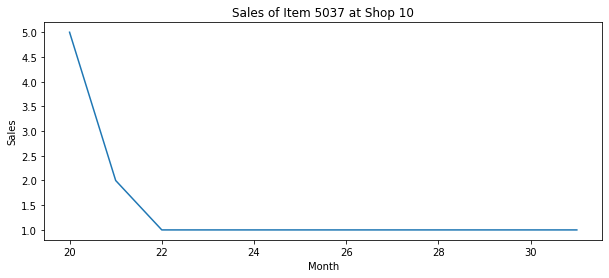

In [8]:
# Interpreting an example

plt.figure(figsize=(10,4))
plt.title('Sales of Item 5037 at Shop 10')
plt.xlabel('Month')
plt.ylabel('Sales')
plt.plot(check["date_block_num"], check["item_cnt_month"]);

In [9]:
num_month = train['date_block_num'].max()
month_list=[i for i in range(num_month+1)]

shop = []
for i in range(num_month+1):
    shop.append(10)
    
item = []

for i in range(num_month+1):
    item.append(5037)
    
ans = pd.DataFrame({'shop_id':shop, 'item_id':item,'date_block_num':month_list})
ans

,shop_id,item_id,date_block_num
0,10,5037,0
1,10,5037,1
2,10,5037,2
3,10,5037,3
4,10,5037,4
5,10,5037,5
6,10,5037,6
7,10,5037,7
8,10,5037,8
9,10,5037,9


In [10]:
ex_sales = pd.merge(check, ans, how = 'right', on = ['shop_id','item_id','date_block_num'])
ex_sales = ex_sales.sort_values(by = ['date_block_num'])
ex_sales.fillna(0.00, inplace=True)
ex_sales

,shop_id,item_id,date_block_num,item_cnt_month
6,10,5037,0,0.0
7,10,5037,1,0.0
8,10,5037,2,0.0
9,10,5037,3,0.0
10,10,5037,4,0.0
11,10,5037,5,0.0
12,10,5037,6,0.0
13,10,5037,7,0.0
14,10,5037,8,0.0
15,10,5037,9,0.0


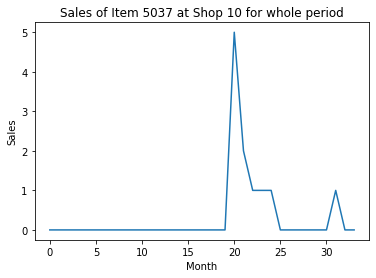

In [11]:
# Interpreting an example

plt.title('Sales of Item 5037 at Shop 10 for whole period')
plt.xlabel('Month')
plt.ylabel('Sales')
plt.plot(ex_sales["date_block_num"], ex_sales["item_cnt_month"]);

In [12]:
for i in range(1,6):
    ex_sales["# " + str(i)] = ex_sales.item_cnt_month.shift(i)
ex_sales.fillna(0.0, inplace=True)
ex_sales

,shop_id,item_id,date_block_num,item_cnt_month,# 1,# 2,# 3,# 4,# 5
6,10,5037,0,0.0,0.0,0.0,0.0,0.0,0.0
7,10,5037,1,0.0,0.0,0.0,0.0,0.0,0.0
8,10,5037,2,0.0,0.0,0.0,0.0,0.0,0.0
9,10,5037,3,0.0,0.0,0.0,0.0,0.0,0.0
10,10,5037,4,0.0,0.0,0.0,0.0,0.0,0.0
11,10,5037,5,0.0,0.0,0.0,0.0,0.0,0.0
12,10,5037,6,0.0,0.0,0.0,0.0,0.0,0.0
13,10,5037,7,0.0,0.0,0.0,0.0,0.0,0.0
14,10,5037,8,0.0,0.0,0.0,0.0,0.0,0.0
15,10,5037,9,0.0,0.0,0.0,0.0,0.0,0.0


In [13]:
df = ex_sales[['shop_id','item_id','date_block_num','# 1','# 2','# 3','# 4','# 5', 'item_cnt_month']].reset_index()
df = df.drop(labels = ['index'], axis = 1)
df

,shop_id,item_id,date_block_num,# 1,# 2,# 3,# 4,# 5,item_cnt_month
0,10,5037,0,0.0,0.0,0.0,0.0,0.0,0.0
1,10,5037,1,0.0,0.0,0.0,0.0,0.0,0.0
2,10,5037,2,0.0,0.0,0.0,0.0,0.0,0.0
3,10,5037,3,0.0,0.0,0.0,0.0,0.0,0.0
4,10,5037,4,0.0,0.0,0.0,0.0,0.0,0.0
5,10,5037,5,0.0,0.0,0.0,0.0,0.0,0.0
6,10,5037,6,0.0,0.0,0.0,0.0,0.0,0.0
7,10,5037,7,0.0,0.0,0.0,0.0,0.0,0.0
8,10,5037,8,0.0,0.0,0.0,0.0,0.0,0.0
9,10,5037,9,0.0,0.0,0.0,0.0,0.0,0.0


## 4. Make Dataset for training

In [39]:
dataset = pd.read_csv('sales_train.csv')
testset = pd.read_csv('test.csv')
dataset.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0


In [40]:
# make our data in desired form 
# we need total count value of an item over the whole month for a shop 

dataset['date'] = pd.to_datetime(dataset['date'],format = '%d.%m.%Y')
dataset = dataset.pivot_table(index = ['shop_id','item_id'], values = ['item_cnt_day'], 
                              columns = ['date_block_num'], fill_value = 0, aggfunc='sum')

dataset.reset_index(inplace = True)  # easy to manipulate
dataset.head()

shop_id item_id item_cnt_day                        ...        \
date_block_num                            0   1  2  3  4  5  6  7  ... 24 25   
0                    0      30            0  31  0  0  0  0  0  0  ...  0  0   
1                    0      31            0  11  0  0  0  0  0  0  ...  0  0   
2                    0      32            6  10  0  0  0  0  0  0  ...  0  0   
3                    0      33            3   3  0  0  0  0  0  0  ...  0  0   
4                    0      35            1  14  0  0  0  0  0  0  ...  0  0   

                                        
date_block_num 26 27 28 29 30 31 32 33  
0               0  0  0  0  0  0  0  0  
1               0  0  0  0  0  0  0  0  
2               0  0  0  0  0  0  0  0  
3               0  0  0  0  0  0  0  0  
4               0  0  0  0  0  0  0  0  

[5 rows x 36 columns]

In [41]:
# we want to keep the data of items we have
dataset = pd.merge(testset,dataset,on = ['item_id','shop_id'],how = 'left')
dataset.drop(['shop_id','item_id','ID'],inplace = True, axis = 1)

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\reshape\merge.py:618: UserWarning: merging between different levels can give an unintended result (1 levels on the left, 2 on the right)
  warnings.warn(msg, UserWarning)
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py:3936: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)


In [42]:
dataset.fillna(0,inplace = True)
dataset.head()

,"(item_cnt_day, 0)","(item_cnt_day, 1)","(item_cnt_day, 2)","(item_cnt_day, 3)","(item_cnt_day, 4)","(item_cnt_day, 5)","(item_cnt_day, 6)","(item_cnt_day, 7)","(item_cnt_day, 8)","(item_cnt_day, 9)",...,"(item_cnt_day, 24)","(item_cnt_day, 25)","(item_cnt_day, 26)","(item_cnt_day, 27)","(item_cnt_day, 28)","(item_cnt_day, 29)","(item_cnt_day, 30)","(item_cnt_day, 31)","(item_cnt_day, 32)","(item_cnt_day, 33)"
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2.0,0.0,0.0,0.0,1.0,1.0,1.0,3.0,1.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,3.0,2.0,0.0,1.0,3.0,1.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [43]:
x_train = np.expand_dims(dataset.values[:,:-1], axis = 2)  # execpt the last one 

y_train = dataset.values[:,-1:] # last column is label

x_test = np.expand_dims(dataset.values[:,1:],axis = 2)  # all the columns execpt the first one

# lets have a look on the shape 
print("Shape of x_train ;", x_train.shape)
print("Shape of y_train :", y_train.shape)
print("Shape of x_test :", x_test.shape)

Shape of x_train ; (214200, 33, 1)
Shape of y_train : (214200, 1)
Shape of x_test : (214200, 33, 1)


## 5. LSTM

In [46]:
model = Sequential()
model.add(LSTM(64, input_shape=(33,1)))
model.add(Dropout(0.4))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mean_squared_error'])
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 64)                16896     
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65        
Total params: 16,961
Trainable params: 16,961
Non-trainable params: 0
_________________________________________________________________


In [53]:
%%time
hist10 = model.fit(x_train,y_train,batch_size = 4096, epochs = 10, verbose=1, shuffle = False)

Epoch 1/10
214200/214200 [==============================] - 56s 260us/step - loss: 30.1989 - mean_squared_error: 30.1989
Epoch 2/10
214200/214200 [==============================] - 56s 260us/step - loss: 30.0581 - mean_squared_error: 30.0581
Epoch 3/10
214200/214200 [==============================] - 56s 261us/step - loss: 29.9824 - mean_squared_error: 29.9824
Epoch 4/10
214200/214200 [==============================] - 56s 260us/step - loss: 29.8648 - mean_squared_error: 29.8648
Epoch 5/10
214200/214200 [==============================] - 58s 271us/step - loss: 29.7735 - mean_squared_error: 29.7735
Epoch 6/10
214200/214200 [==============================] - 60s 280us/step - loss: 29.7677 - mean_squared_error: 29.7677
Epoch 7/10
214200/214200 [==============================] - 59s 277us/step - loss: 29.6869 - mean_squared_error: 29.6869
Epoch 8/10
214200/214200 [==============================] - 60s 279us/step - loss: 29.7081 - mean_squared_error: 29.7081
Epoch 9/10
214200/214200 [======

In [64]:
%%time
hist50 = model.fit(x_train,y_train,batch_size = 4096, epochs = 50, verbose=1, shuffle = False)

Epoch 1/50
214200/214200 [==============================] - 55s 256us/step - loss: 29.5999 - mean_squared_error: 29.5999
Epoch 2/50
214200/214200 [==============================] - 57s 264us/step - loss: 29.4247 - mean_squared_error: 29.4247
Epoch 3/50
214200/214200 [==============================] - 57s 264us/step - loss: 29.4045 - mean_squared_error: 29.4045
Epoch 4/50
214200/214200 [==============================] - 60s 280us/step - loss: 29.3600 - mean_squared_error: 29.3600
Epoch 5/50
214200/214200 [==============================] - 57s 265us/step - loss: 29.3418 - mean_squared_error: 29.3418
Epoch 6/50
214200/214200 [==============================] - 56s 260us/step - loss: 29.2870 - mean_squared_error: 29.2870
Epoch 7/50
214200/214200 [==============================] - 66s 307us/step - loss: 29.2877 - mean_squared_error: 29.2877
Epoch 8/50
214200/214200 [==============================] - 67s 311us/step - loss: 29.1093 - mean_squared_error: 29.1093
Epoch 9/50
214200/214200 [======

In [65]:
my_submission1 = model.predict(x_test)

# we will keep every value between 0 and 20
my_submission1 = my_submission1.clip(0, 20)

submission1 = pd.DataFrame({'ID':testset['ID'],'item_cnt_month':my_submission1.ravel()})

submission1.to_csv('lstm60_submission.csv',index = False)